In [41]:
import torch
import torchvision
import torchvision.datasets as datasets
from tqdm import tqdm
import argparse
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn
import os
import sys
import logging
import logging.handlers
from PIL import Image

# Parser

In [42]:
parser = argparse.ArgumentParser(description='Domain adaptation')
parser.add_argument("--batch_size", type=int, default="100", help="batch size")
parser.add_argument("--learning_rate", type=float, default=1e-2, help="learning rate")
parser.add_argument("--momentum", type=float, default=0.5, help="momentum")
parser.add_argument("--gpu_num", type=int, default=0, help="gpu num")
parser.add_argument("--seed", type=int, default=123, help="munually set seed")
parser.add_argument("--save_path", type=str, default=r"C:\Users\Tianqin Li\Code\PGM-project\train_related", help="save path")
parser.add_argument("--subfolder", type=str, default=r'\baseline_st', help="subfolder name")
parser.add_argument("--wtarget", type=float, default=0.7, help="target weight")
parser.add_argument("--model_save_period", type=int, default=2, help="save period")


args = parser.parse_args()

usage: ipykernel_launcher.py [-h] [--batch_size BATCH_SIZE]
                             [--learning_rate LEARNING_RATE]
                             [--momentum MOMENTUM] [--gpu_num GPU_NUM]
                             [--seed SEED] [--save_path SAVE_PATH]
                             [--subfolder SUBFOLDER] [--wtarget WTARGET]
                             [--model_save_period MODEL_SAVE_PERIOD]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\Tianqin Li\AppData\Roaming\jupyter\runtime\kernel-eba4e740-e0bd-41bf-885a-41405d939a5e.json


SystemExit: 2

C:\Users\Tianqin Li\anaconda3\envs\russ-local\lib\site-packages\IPython\core\interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# local only

In [44]:
# local only
class local_args:
    def __init__(self, **entries):
        self.__dict__.update(entries)
        
args = local_args(**{
    'batch_size': 400,
    'learning_rate': 1e-3,
    'momentum': 0.5,
    'gpu_num': 0,
    'seed': 123,
    'save_path': r"C:\Users\Tianqin Li\Code\PGM-project\train_related",
    'epochs': 200,
    'subfolder': r'\dann_source_only_shffle',
    'wtarget': 0.7,
    'dann_weight': 1,
    'model_save_period': 2,
})

In [45]:

device = torch.device('cuda:{}'.format(args.gpu_num) if torch.cuda.is_available() else 'cpu')
# seed
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
cudnn.deterministic = True
torch.backends.cudnn.deterministic = True



device = torch.device('cuda:{}'.format(args.gpu_num) if torch.cuda.is_available() else 'cpu')

 
model_sub_folder = args.subfolder + '\wtarget_%f_dann_weight_%f_learningrate_%f'%(args.wtarget, args.dann_weight, args.learning_rate)

if not os.path.exists(args.save_path+model_sub_folder):
    os.makedirs(args.save_path+model_sub_folder)

In [46]:

logger = logging.getLogger()
logger.setLevel(logging.INFO)

if os.path.isfile(args.save_path+model_sub_folder+ '\logfile.log'):
    os.remove(args.save_path+model_sub_folder+ '\logfile.log')
    
file_log_handler = logging.FileHandler(args.save_path+model_sub_folder+ '\logfile.log')
logger.addHandler(file_log_handler)

stdout_log_handler = logging.StreamHandler(sys.stdout)
logger.addHandler(stdout_log_handler)

attrs = vars(args)
for item in attrs.items():
    logger.info("%s: %s"%item)


batch_size: 400
batch_size: 400
batch_size: 400
learning_rate: 0.001
learning_rate: 0.001
learning_rate: 0.001
momentum: 0.5
momentum: 0.5
momentum: 0.5
gpu_num: 0
gpu_num: 0
gpu_num: 0
seed: 123
seed: 123
seed: 123
save_path: C:\Users\Tianqin Li\Code\PGM-project\train_related
save_path: C:\Users\Tianqin Li\Code\PGM-project\train_related
save_path: C:\Users\Tianqin Li\Code\PGM-project\train_related
epochs: 200
epochs: 200
epochs: 200
subfolder: \dann_source_only_shffle
subfolder: \dann_source_only_shffle
subfolder: \dann_source_only_shffle
wtarget: 0.7
wtarget: 0.7
wtarget: 0.7
dann_weight: 1
dann_weight: 1
dann_weight: 1
model_save_period: 2
model_save_period: 2
model_save_period: 2


# Data loader

In [47]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

In [48]:
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

In [49]:
svhn_trainset = datasets.SVHN(root='./data', split='train', download=True, transform=torchvision.transforms.Compose([
                    torchvision.transforms.Resize((28, 28)),
                    torchvision.transforms.Grayscale(num_output_channels=1),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize([0.5], [0.5])]))

Using downloaded and verified file: ./data\train_32x32.mat


In [50]:
svhn_testset = datasets.SVHN(root='./data', split='test', download=True, transform=torchvision.transforms.Compose([
                    torchvision.transforms.Resize((28, 28)),
                    torchvision.transforms.Grayscale(num_output_channels=1),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize([0.5], [0.5])]))

Using downloaded and verified file: ./data\test_32x32.mat


In [51]:
# # mnist
# train_mnist_loader = DataLoader(mnist_trainset, batch_size=args.batch_size, shuffle=True)
# test_mnist_loader = DataLoader(mnist_testset, batch_size=args.batch_size, shuffle=True)
# examples = enumerate(test_mnist_loader)
# batch_idx, (example_data, example_targets) = next(examples)


# fig = plt.figure()
# for i in range(6):
#   plt.subplot(2,3,i+1)
#   plt.tight_layout()
#   plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
#   plt.title("Ground Truth: {}".format(example_targets[i]))
#   plt.xticks([])
#   plt.yticks([])

In [52]:
# # svhn
# train_svhn_loader = DataLoader(svhn_trainset, batch_size=args.batch_size, shuffle=True)
# test_svhn_loader = DataLoader(svhn_trainset, batch_size=args.batch_size, shuffle=True)
# examples = enumerate(train_svhn_loader)
# batch_idx, (example_data, example_targets) = next(examples)


# fig = plt.figure()
# for i in range(6):
#   plt.subplot(2,3,i+1)
#   plt.tight_layout()
#   plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
#   plt.title("Ground Truth: {}".format(example_targets[i]))
#   plt.xticks([])
#   plt.yticks([])

In [53]:
# reload data
train_mnist_loader = DataLoader(mnist_trainset, batch_size=args.batch_size, shuffle=True)
test_mnist_loader = DataLoader(mnist_testset, batch_size=args.batch_size, shuffle=True)
train_svhn_loader = DataLoader(svhn_trainset, batch_size=args.batch_size, shuffle=True)
test_svhn_loader = DataLoader(svhn_trainset, batch_size=args.batch_size, shuffle=True)

## Process data for cancat with source and target label

In [54]:
class ConcatDataset(Dataset):
    def __init__(self, x, y, mode='mnist'):
        self.x = x
        self.y = y
        self.len = self.x.shape[0]
        self.mode = mode
        if self.mode == 'mnist':
            self.transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])
        elif self.mode == 'svhn':
            self.transform = torchvision.transforms.Compose([
                    torchvision.transforms.Resize((28, 28)),
                    torchvision.transforms.Grayscale(num_output_channels=1),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize([0.5], [0.5])])

    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        if self.mode == 'mnist':
            img = Image.fromarray(self.x[index].numpy(), mode='L')
            img = self.transform(img)
        elif self.mode == 'svhn':
            img = Image.fromarray(np.transpose(self.x[index], (1, 2, 0)))
            img = self.transform(img)
    
        return img, self.y[index]

In [55]:

concat_mnist_train = ConcatDataset(mnist_trainset.data, torch.randint(0,2,(mnist_trainset.data.shape[0],)), mode = 'mnist')
concat_svhn_train = ConcatDataset(svhn_trainset.data, torch.randint(0,2,(svhn_trainset.data.shape[0],)), mode = 'svhn')


adverial_dataset = torch.utils.data.ConcatDataset([concat_mnist_train, concat_svhn_train])
# [i[1] for i in [adverial_dataset[m] for m in torch.randint(0, len(adverial_dataset), (100,))]]
adverial_loader = DataLoader(adverial_dataset, batch_size=args.batch_size, shuffle=True)

# Model

In [56]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 30)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [80]:
class FNN(nn.Module):
    def __init__(self, d_in, d_h1, d_h2, d_out, dp=0.2):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(d_in, d_h1)
        self.ln1 = nn.LayerNorm(d_h1)
        self.relu1 = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(dp)
        self.fc2 = nn.Linear(d_h1, d_h2)
        self.ln2 = nn.LayerNorm(d_h2)
        self.relu2 = nn.ReLU(inplace=True)
        self.dropout2 = nn.Dropout(dp)
        self.fc3 = nn.Linear(d_h2, d_out)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ln1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.ln2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x
    
    def before_lastlinear(self, x):
        x = self.fc1(x)
        x = self.ln1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.ln2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        return x

        

In [58]:
class Adversial_loss(nn.Module):
    def __init__(self):
        super(Adversial_loss, self).__init__()
    
    def forward(self):
        pass

In [59]:
def weights_init(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
    elif type(m) == nn.LayerNorm:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)


In [60]:

device = torch.device('cuda:{}'.format(args.gpu_num) if torch.cuda.is_available() else 'cpu')
print(device)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)

encoder = Encoder().to(device)
CNet = FNN(d_in=30, d_h1=100, d_h2=100, d_out=10, dp=0.2).to(device)
DomainCNet = FNN(d_in=30, d_h1=100, d_h2=100, d_out=2, dp=0.2).to(device)




optimizerEncoder = optim.Adam(encoder.parameters(), lr=args.learning_rate)
optimizerCNet = optim.Adam(CNet.parameters(), lr=args.learning_rate)
optimizerDomainCNet = optim.Adam(DomainCNet.parameters(), lr=args.learning_rate)

criterion_classifier = nn.CrossEntropyLoss().to(device)
# criterion_adverisal = 

encoder.apply(weights_init)
CNet.apply(weights_init)
DomainCNet.apply(weights_init)

cuda:0


FNN(
  (fc1): Linear(in_features=30, out_features=100, bias=True)
  (ln1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (relu1): ReLU(inplace=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (ln2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (relu2): ReLU(inplace=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=100, out_features=2, bias=True)
)

# Train

In [61]:
target_acc_label_ = []
source_acc_ = []
source_test_acc_ = []
target_test_acc_ = []

logger.info('Started Training')


for epoch in range(args.epochs):
    # update classifier
    # on source domain mnist
    CNet.train()
    encoder.train()
    source_acc = 0.0
    num_datas = 0.0
    for batch_id, (source_x, source_y) in tqdm(enumerate(train_mnist_loader), total=len(train_mnist_loader)):
        optimizerCNet.zero_grad()
        optimizerEncoder.zero_grad()
        source_x = source_x.to(device).float()
        source_y = source_y.to(device)
        num_datas += source_x.size(0)
        source_x_embedding = encoder(source_x)
        pred = CNet(source_x_embedding)
        source_acc += (pred.argmax(-1) == source_y).sum().item()
        loss = criterion_classifier(pred, source_y)
        loss.backward()
        optimizerCNet.step()
        optimizerEncoder.step()
        
        
    source_acc = source_acc / num_datas
    source_acc_.append(source_acc)
    
    
    
    # on target domain svhn
#     target_acc = 0.0
#     num_datas = 0.0
#     CNet.train()
#     encoder.train()

#     for batch_id, (target_x, target_y) in tqdm(enumerate(train_svhn_loader), total=len(train_svhn_loader)):
#         optimizerCNet.zero_grad()
#         optimizerEncoder.zero_grad()
#         target_x = target_x.to(device).float()
#         target_y = target_y.to(device)
#         num_datas += target_x.size(0)
#         target_x_embedding = encoder(target_x)
#         pred = CNet(target_x_embedding)
#         target_acc += (pred.argmax(-1) == target_y).sum().item()
#         loss = criterion_classifier(pred, target_y)
#         loss.backward()
#         optimizerCNet.step()
#         optimizerEncoder.step()
        
    
#     target_acc = target_acc / num_datas
#     target_acc_label_.append(target_acc)
    
    
    # DANN
    DomainCNet.train()
    encoder.train()
    num_datas = 0.0
    for batch_id, (adv_x, adv_y) in tqdm(enumerate(adverial_loader), total=len(adverial_loader)):
        optimizerCNet.zero_grad()
        optimizerEncoder.zero_grad()
        adv_x = adv_x.to(device).float()
        adv_y = adv_y.to(device)
        num_datas += adv_x.size(0)
        adv_x_embedding = encoder(adv_x)
        pred = DomainCNet(adv_x_embedding)
        # adv_acc += (pred.argmax(-1) == adv_y).sum().item()
        loss = args.dann_weight * criterion_classifier(pred, adv_y)
        loss.backward()
        optimizerEncoder.step()
        optimizerDomainCNet.step()
    
    
    
    
    
    # eval on source   
    source_test_acc = 0.0
    num_datas = 0.0
    CNet.eval()
    encoder.eval()
    
    for batch_id, (source_x, source_y) in enumerate(test_mnist_loader):
        optimizerCNet.zero_grad()
        optimizerEncoder.zero_grad()
        source_x = source_x.to(device).float()
        source_y = source_y.to(device)
        num_datas += source_x.size(0)
        source_x_embedding = encoder(source_x)
        pred = CNet(source_x_embedding)
        source_test_acc += (pred.argmax(-1) == source_y).sum().item()
        
    source_test_acc = source_test_acc / num_datas
    source_test_acc_.append(source_test_acc)
    
    # eval on target 
    num_datas = 0.0
    target_test_acc = 0.0
    for batch_id, (target_x, target_y) in enumerate(test_svhn_loader):
        optimizerCNet.zero_grad()
        optimizerEncoder.zero_grad()
        target_x = target_x.to(device).float()
        target_y = target_y.to(device)
        num_datas += target_x.size(0)
        target_x_embedding = encoder(target_x)
        pred = CNet(target_x_embedding)
        target_test_acc += (pred.argmax(-1) == target_y).sum().item()
    
    target_test_acc = target_test_acc / num_datas
    target_test_acc_.append(source_test_acc)
    
    if epoch % args.model_save_period == 0:
        torch.save(DomainCNet.state_dict(), args.save_path+model_sub_folder+ '/DomainCNet_%i.t7'%(epoch+1))
        torch.save(encoder.state_dict(), args.save_path+model_sub_folder+ '/encoder_%i.t7'%(epoch+1))
        torch.save(CNet.state_dict(), args.save_path+model_sub_folder+ '/CNet_%i.t7'%(epoch+1))

    
    logger.info('Epochs %i: source train acc: %f; source test acc: %f; target test acc: %f'%(epoch+1, source_acc, source_test_acc, target_test_acc))
    

Started Training
Started Training
Started Training


100%|██████████| 334/334 [00:23<00:00, 14.22it/s]


Epochs 1: source train acc: 0.545367; source test acc: 0.205700; target test acc: 0.077699
Epochs 1: source train acc: 0.545367; source test acc: 0.205700; target test acc: 0.077699
Epochs 1: source train acc: 0.545367; source test acc: 0.205700; target test acc: 0.077699


100%|██████████| 334/334 [00:23<00:00, 14.23it/s]


Epochs 2: source train acc: 0.814567; source test acc: 0.914500; target test acc: 0.161418
Epochs 2: source train acc: 0.814567; source test acc: 0.914500; target test acc: 0.161418
Epochs 2: source train acc: 0.814567; source test acc: 0.914500; target test acc: 0.161418


100%|██████████| 334/334 [00:23<00:00, 14.37it/s]


Epochs 3: source train acc: 0.887900; source test acc: 0.965100; target test acc: 0.232797
Epochs 3: source train acc: 0.887900; source test acc: 0.965100; target test acc: 0.232797
Epochs 3: source train acc: 0.887900; source test acc: 0.965100; target test acc: 0.232797


100%|██████████| 334/334 [00:23<00:00, 14.24it/s]


Epochs 4: source train acc: 0.911250; source test acc: 0.971300; target test acc: 0.222654
Epochs 4: source train acc: 0.911250; source test acc: 0.971300; target test acc: 0.222654
Epochs 4: source train acc: 0.911250; source test acc: 0.971300; target test acc: 0.222654


100%|██████████| 334/334 [00:23<00:00, 14.21it/s]


Epochs 5: source train acc: 0.924400; source test acc: 0.974500; target test acc: 0.233548
Epochs 5: source train acc: 0.924400; source test acc: 0.974500; target test acc: 0.233548
Epochs 5: source train acc: 0.924400; source test acc: 0.974500; target test acc: 0.233548


100%|██████████| 334/334 [00:23<00:00, 14.09it/s]


Epochs 6: source train acc: 0.932283; source test acc: 0.980300; target test acc: 0.243704
Epochs 6: source train acc: 0.932283; source test acc: 0.980300; target test acc: 0.243704
Epochs 6: source train acc: 0.932283; source test acc: 0.980300; target test acc: 0.243704


100%|██████████| 334/334 [00:23<00:00, 14.08it/s]


Epochs 7: source train acc: 0.938450; source test acc: 0.979300; target test acc: 0.227309
Epochs 7: source train acc: 0.938450; source test acc: 0.979300; target test acc: 0.227309
Epochs 7: source train acc: 0.938450; source test acc: 0.979300; target test acc: 0.227309


100%|██████████| 334/334 [00:24<00:00, 13.90it/s]


Epochs 8: source train acc: 0.942100; source test acc: 0.981600; target test acc: 0.230135
Epochs 8: source train acc: 0.942100; source test acc: 0.981600; target test acc: 0.230135
Epochs 8: source train acc: 0.942100; source test acc: 0.981600; target test acc: 0.230135


100%|██████████| 334/334 [00:23<00:00, 14.21it/s]


Epochs 9: source train acc: 0.946850; source test acc: 0.978900; target test acc: 0.213222
Epochs 9: source train acc: 0.946850; source test acc: 0.978900; target test acc: 0.213222
Epochs 9: source train acc: 0.946850; source test acc: 0.978900; target test acc: 0.213222


100%|██████████| 334/334 [00:23<00:00, 14.12it/s]


Epochs 10: source train acc: 0.948183; source test acc: 0.981300; target test acc: 0.223050
Epochs 10: source train acc: 0.948183; source test acc: 0.981300; target test acc: 0.223050
Epochs 10: source train acc: 0.948183; source test acc: 0.981300; target test acc: 0.223050


100%|██████████| 334/334 [00:23<00:00, 14.11it/s]


Epochs 11: source train acc: 0.949783; source test acc: 0.981100; target test acc: 0.243472
Epochs 11: source train acc: 0.949783; source test acc: 0.981100; target test acc: 0.243472
Epochs 11: source train acc: 0.949783; source test acc: 0.981100; target test acc: 0.243472


100%|██████████| 334/334 [00:23<00:00, 14.05it/s]


Epochs 12: source train acc: 0.953433; source test acc: 0.980100; target test acc: 0.250010
Epochs 12: source train acc: 0.953433; source test acc: 0.980100; target test acc: 0.250010
Epochs 12: source train acc: 0.953433; source test acc: 0.980100; target test acc: 0.250010


100%|██████████| 334/334 [00:23<00:00, 13.93it/s]


Epochs 13: source train acc: 0.952350; source test acc: 0.981600; target test acc: 0.254802
Epochs 13: source train acc: 0.952350; source test acc: 0.981600; target test acc: 0.254802
Epochs 13: source train acc: 0.952350; source test acc: 0.981600; target test acc: 0.254802


100%|██████████| 334/334 [00:24<00:00, 13.88it/s]


Epochs 14: source train acc: 0.955667; source test acc: 0.984300; target test acc: 0.236210
Epochs 14: source train acc: 0.955667; source test acc: 0.984300; target test acc: 0.236210
Epochs 14: source train acc: 0.955667; source test acc: 0.984300; target test acc: 0.236210


100%|██████████| 334/334 [00:23<00:00, 13.97it/s]


Epochs 15: source train acc: 0.957733; source test acc: 0.986200; target test acc: 0.240933
Epochs 15: source train acc: 0.957733; source test acc: 0.986200; target test acc: 0.240933
Epochs 15: source train acc: 0.957733; source test acc: 0.986200; target test acc: 0.240933


100%|██████████| 334/334 [00:24<00:00, 13.55it/s]


Epochs 16: source train acc: 0.957350; source test acc: 0.986600; target test acc: 0.236633
Epochs 16: source train acc: 0.957350; source test acc: 0.986600; target test acc: 0.236633
Epochs 16: source train acc: 0.957350; source test acc: 0.986600; target test acc: 0.236633


100%|██████████| 334/334 [00:23<00:00, 14.05it/s]


Epochs 17: source train acc: 0.960283; source test acc: 0.986000; target test acc: 0.235240
Epochs 17: source train acc: 0.960283; source test acc: 0.986000; target test acc: 0.235240
Epochs 17: source train acc: 0.960283; source test acc: 0.986000; target test acc: 0.235240


100%|██████████| 334/334 [00:23<00:00, 14.02it/s]


Epochs 18: source train acc: 0.959950; source test acc: 0.986000; target test acc: 0.230736
Epochs 18: source train acc: 0.959950; source test acc: 0.986000; target test acc: 0.230736
Epochs 18: source train acc: 0.959950; source test acc: 0.986000; target test acc: 0.230736


100%|██████████| 334/334 [00:24<00:00, 13.77it/s]


Epochs 19: source train acc: 0.961000; source test acc: 0.987600; target test acc: 0.222504
Epochs 19: source train acc: 0.961000; source test acc: 0.987600; target test acc: 0.222504
Epochs 19: source train acc: 0.961000; source test acc: 0.987600; target test acc: 0.222504


100%|██████████| 334/334 [00:23<00:00, 14.11it/s]


Epochs 20: source train acc: 0.960300; source test acc: 0.986400; target test acc: 0.235977
Epochs 20: source train acc: 0.960300; source test acc: 0.986400; target test acc: 0.235977
Epochs 20: source train acc: 0.960300; source test acc: 0.986400; target test acc: 0.235977


100%|██████████| 334/334 [00:23<00:00, 14.07it/s]


Epochs 21: source train acc: 0.960917; source test acc: 0.986300; target test acc: 0.219119
Epochs 21: source train acc: 0.960917; source test acc: 0.986300; target test acc: 0.219119
Epochs 21: source train acc: 0.960917; source test acc: 0.986300; target test acc: 0.219119


100%|██████████| 334/334 [00:23<00:00, 14.11it/s]


Epochs 22: source train acc: 0.961717; source test acc: 0.988400; target test acc: 0.228033
Epochs 22: source train acc: 0.961717; source test acc: 0.988400; target test acc: 0.228033
Epochs 22: source train acc: 0.961717; source test acc: 0.988400; target test acc: 0.228033


100%|██████████| 334/334 [00:24<00:00, 13.78it/s]


Epochs 23: source train acc: 0.961167; source test acc: 0.988100; target test acc: 0.229316
Epochs 23: source train acc: 0.961167; source test acc: 0.988100; target test acc: 0.229316
Epochs 23: source train acc: 0.961167; source test acc: 0.988100; target test acc: 0.229316


100%|██████████| 334/334 [00:24<00:00, 13.76it/s]


Epochs 24: source train acc: 0.963317; source test acc: 0.987000; target test acc: 0.224743
Epochs 24: source train acc: 0.963317; source test acc: 0.987000; target test acc: 0.224743
Epochs 24: source train acc: 0.963317; source test acc: 0.987000; target test acc: 0.224743


100%|██████████| 334/334 [00:23<00:00, 14.00it/s]


Epochs 25: source train acc: 0.963583; source test acc: 0.986700; target test acc: 0.222177
Epochs 25: source train acc: 0.963583; source test acc: 0.986700; target test acc: 0.222177
Epochs 25: source train acc: 0.963583; source test acc: 0.986700; target test acc: 0.222177


100%|██████████| 334/334 [00:23<00:00, 13.93it/s]


Epochs 26: source train acc: 0.964200; source test acc: 0.989500; target test acc: 0.214764
Epochs 26: source train acc: 0.964200; source test acc: 0.989500; target test acc: 0.214764
Epochs 26: source train acc: 0.964200; source test acc: 0.989500; target test acc: 0.214764


100%|██████████| 334/334 [00:23<00:00, 13.96it/s]


Epochs 27: source train acc: 0.965283; source test acc: 0.987000; target test acc: 0.221030
Epochs 27: source train acc: 0.965283; source test acc: 0.987000; target test acc: 0.221030
Epochs 27: source train acc: 0.965283; source test acc: 0.987000; target test acc: 0.221030


100%|██████████| 334/334 [00:23<00:00, 13.95it/s]


Epochs 28: source train acc: 0.965717; source test acc: 0.988500; target test acc: 0.211871
Epochs 28: source train acc: 0.965717; source test acc: 0.988500; target test acc: 0.211871
Epochs 28: source train acc: 0.965717; source test acc: 0.988500; target test acc: 0.211871


100%|██████████| 334/334 [00:23<00:00, 14.05it/s]


Epochs 29: source train acc: 0.965383; source test acc: 0.988300; target test acc: 0.222545
Epochs 29: source train acc: 0.965383; source test acc: 0.988300; target test acc: 0.222545
Epochs 29: source train acc: 0.965383; source test acc: 0.988300; target test acc: 0.222545


100%|██████████| 334/334 [00:23<00:00, 14.03it/s]


Epochs 30: source train acc: 0.965867; source test acc: 0.988900; target test acc: 0.225699
Epochs 30: source train acc: 0.965867; source test acc: 0.988900; target test acc: 0.225699
Epochs 30: source train acc: 0.965867; source test acc: 0.988900; target test acc: 0.225699


100%|██████████| 334/334 [00:23<00:00, 14.13it/s]


Epochs 31: source train acc: 0.966200; source test acc: 0.988400; target test acc: 0.230558
Epochs 31: source train acc: 0.966200; source test acc: 0.988400; target test acc: 0.230558
Epochs 31: source train acc: 0.966200; source test acc: 0.988400; target test acc: 0.230558


100%|██████████| 334/334 [00:23<00:00, 13.98it/s]


Epochs 32: source train acc: 0.966233; source test acc: 0.987000; target test acc: 0.231596
Epochs 32: source train acc: 0.966233; source test acc: 0.987000; target test acc: 0.231596
Epochs 32: source train acc: 0.966233; source test acc: 0.987000; target test acc: 0.231596


100%|██████████| 334/334 [00:24<00:00, 13.82it/s]


Epochs 33: source train acc: 0.966067; source test acc: 0.988400; target test acc: 0.226681
Epochs 33: source train acc: 0.966067; source test acc: 0.988400; target test acc: 0.226681
Epochs 33: source train acc: 0.966067; source test acc: 0.988400; target test acc: 0.226681


100%|██████████| 334/334 [00:23<00:00, 13.94it/s]


Epochs 34: source train acc: 0.967550; source test acc: 0.988800; target test acc: 0.219324
Epochs 34: source train acc: 0.967550; source test acc: 0.988800; target test acc: 0.219324
Epochs 34: source train acc: 0.967550; source test acc: 0.988800; target test acc: 0.219324


100%|██████████| 334/334 [00:23<00:00, 13.95it/s]


Epochs 35: source train acc: 0.967750; source test acc: 0.988700; target test acc: 0.212785
Epochs 35: source train acc: 0.967750; source test acc: 0.988700; target test acc: 0.212785
Epochs 35: source train acc: 0.967750; source test acc: 0.988700; target test acc: 0.212785


100%|██████████| 334/334 [00:24<00:00, 13.45it/s]


Epochs 36: source train acc: 0.968017; source test acc: 0.988000; target test acc: 0.232196
Epochs 36: source train acc: 0.968017; source test acc: 0.988000; target test acc: 0.232196
Epochs 36: source train acc: 0.968017; source test acc: 0.988000; target test acc: 0.232196


100%|██████████| 334/334 [00:23<00:00, 13.94it/s]


Epochs 37: source train acc: 0.969067; source test acc: 0.988400; target test acc: 0.209086
Epochs 37: source train acc: 0.969067; source test acc: 0.988400; target test acc: 0.209086
Epochs 37: source train acc: 0.969067; source test acc: 0.988400; target test acc: 0.209086


100%|██████████| 334/334 [00:23<00:00, 13.93it/s]


Epochs 38: source train acc: 0.967633; source test acc: 0.989900; target test acc: 0.224306
Epochs 38: source train acc: 0.967633; source test acc: 0.989900; target test acc: 0.224306
Epochs 38: source train acc: 0.967633; source test acc: 0.989900; target test acc: 0.224306


100%|██████████| 334/334 [00:23<00:00, 13.99it/s]


Epochs 39: source train acc: 0.968633; source test acc: 0.988500; target test acc: 0.233493
Epochs 39: source train acc: 0.968633; source test acc: 0.988500; target test acc: 0.233493
Epochs 39: source train acc: 0.968633; source test acc: 0.988500; target test acc: 0.233493


100%|██████████| 334/334 [00:23<00:00, 13.95it/s]


Epochs 40: source train acc: 0.968950; source test acc: 0.990500; target test acc: 0.219993
Epochs 40: source train acc: 0.968950; source test acc: 0.990500; target test acc: 0.219993
Epochs 40: source train acc: 0.968950; source test acc: 0.990500; target test acc: 0.219993


100%|██████████| 334/334 [00:24<00:00, 13.56it/s]


Epochs 41: source train acc: 0.969000; source test acc: 0.987300; target test acc: 0.229521
Epochs 41: source train acc: 0.969000; source test acc: 0.987300; target test acc: 0.229521
Epochs 41: source train acc: 0.969000; source test acc: 0.987300; target test acc: 0.229521


100%|██████████| 334/334 [00:24<00:00, 13.54it/s]


Epochs 42: source train acc: 0.968667; source test acc: 0.989500; target test acc: 0.225357
Epochs 42: source train acc: 0.968667; source test acc: 0.989500; target test acc: 0.225357
Epochs 42: source train acc: 0.968667; source test acc: 0.989500; target test acc: 0.225357


100%|██████████| 334/334 [00:24<00:00, 13.45it/s]


Epochs 43: source train acc: 0.968750; source test acc: 0.986900; target test acc: 0.226504
Epochs 43: source train acc: 0.968750; source test acc: 0.986900; target test acc: 0.226504
Epochs 43: source train acc: 0.968750; source test acc: 0.986900; target test acc: 0.226504


100%|██████████| 334/334 [00:25<00:00, 13.12it/s]


Epochs 44: source train acc: 0.968317; source test acc: 0.988700; target test acc: 0.213986
Epochs 44: source train acc: 0.968317; source test acc: 0.988700; target test acc: 0.213986
Epochs 44: source train acc: 0.968317; source test acc: 0.988700; target test acc: 0.213986


100%|██████████| 334/334 [00:25<00:00, 13.05it/s]


Epochs 45: source train acc: 0.969417; source test acc: 0.989200; target test acc: 0.218013
Epochs 45: source train acc: 0.969417; source test acc: 0.989200; target test acc: 0.218013
Epochs 45: source train acc: 0.969417; source test acc: 0.989200; target test acc: 0.218013


100%|██████████| 334/334 [00:25<00:00, 13.26it/s]


Epochs 46: source train acc: 0.970617; source test acc: 0.989800; target test acc: 0.220498
Epochs 46: source train acc: 0.970617; source test acc: 0.989800; target test acc: 0.220498
Epochs 46: source train acc: 0.970617; source test acc: 0.989800; target test acc: 0.220498


100%|██████████| 334/334 [00:25<00:00, 13.31it/s]


Epochs 47: source train acc: 0.969967; source test acc: 0.989400; target test acc: 0.218887
Epochs 47: source train acc: 0.969967; source test acc: 0.989400; target test acc: 0.218887
Epochs 47: source train acc: 0.969967; source test acc: 0.989400; target test acc: 0.218887


100%|██████████| 334/334 [00:25<00:00, 13.05it/s]


Epochs 48: source train acc: 0.970267; source test acc: 0.990700; target test acc: 0.227214
Epochs 48: source train acc: 0.970267; source test acc: 0.990700; target test acc: 0.227214
Epochs 48: source train acc: 0.970267; source test acc: 0.990700; target test acc: 0.227214


100%|██████████| 334/334 [00:26<00:00, 12.72it/s]


Epochs 49: source train acc: 0.969733; source test acc: 0.990400; target test acc: 0.211106
Epochs 49: source train acc: 0.969733; source test acc: 0.990400; target test acc: 0.211106
Epochs 49: source train acc: 0.969733; source test acc: 0.990400; target test acc: 0.211106


100%|██████████| 334/334 [00:25<00:00, 12.89it/s]


Epochs 50: source train acc: 0.970700; source test acc: 0.989400; target test acc: 0.223856
Epochs 50: source train acc: 0.970700; source test acc: 0.989400; target test acc: 0.223856
Epochs 50: source train acc: 0.970700; source test acc: 0.989400; target test acc: 0.223856


100%|██████████| 334/334 [00:25<00:00, 13.03it/s]


Epochs 51: source train acc: 0.969850; source test acc: 0.988700; target test acc: 0.224825
Epochs 51: source train acc: 0.969850; source test acc: 0.988700; target test acc: 0.224825
Epochs 51: source train acc: 0.969850; source test acc: 0.988700; target test acc: 0.224825


100%|██████████| 334/334 [00:25<00:00, 13.10it/s]


Epochs 52: source train acc: 0.970300; source test acc: 0.988800; target test acc: 0.212335
Epochs 52: source train acc: 0.970300; source test acc: 0.988800; target test acc: 0.212335
Epochs 52: source train acc: 0.970300; source test acc: 0.988800; target test acc: 0.212335


100%|██████████| 334/334 [00:25<00:00, 12.93it/s]


Epochs 53: source train acc: 0.970783; source test acc: 0.987200; target test acc: 0.204636
Epochs 53: source train acc: 0.970783; source test acc: 0.987200; target test acc: 0.204636
Epochs 53: source train acc: 0.970783; source test acc: 0.987200; target test acc: 0.204636


100%|██████████| 334/334 [00:25<00:00, 12.98it/s]


Epochs 54: source train acc: 0.970750; source test acc: 0.989800; target test acc: 0.218942
Epochs 54: source train acc: 0.970750; source test acc: 0.989800; target test acc: 0.218942
Epochs 54: source train acc: 0.970750; source test acc: 0.989800; target test acc: 0.218942


100%|██████████| 334/334 [00:25<00:00, 12.96it/s]


Epochs 55: source train acc: 0.972850; source test acc: 0.988600; target test acc: 0.228470
Epochs 55: source train acc: 0.972850; source test acc: 0.988600; target test acc: 0.228470
Epochs 55: source train acc: 0.972850; source test acc: 0.988600; target test acc: 0.228470


100%|██████████| 334/334 [00:27<00:00, 12.31it/s]


Epochs 56: source train acc: 0.972533; source test acc: 0.986200; target test acc: 0.209686
Epochs 56: source train acc: 0.972533; source test acc: 0.986200; target test acc: 0.209686
Epochs 56: source train acc: 0.972533; source test acc: 0.986200; target test acc: 0.209686


100%|██████████| 334/334 [00:25<00:00, 12.95it/s]


Epochs 57: source train acc: 0.970783; source test acc: 0.990800; target test acc: 0.219665
Epochs 57: source train acc: 0.970783; source test acc: 0.990800; target test acc: 0.219665
Epochs 57: source train acc: 0.970783; source test acc: 0.990800; target test acc: 0.219665


100%|██████████| 334/334 [00:26<00:00, 12.56it/s]


Epochs 58: source train acc: 0.971150; source test acc: 0.990400; target test acc: 0.213700
Epochs 58: source train acc: 0.971150; source test acc: 0.990400; target test acc: 0.213700
Epochs 58: source train acc: 0.971150; source test acc: 0.990400; target test acc: 0.213700


100%|██████████| 334/334 [00:25<00:00, 13.08it/s]


Epochs 59: source train acc: 0.972600; source test acc: 0.989200; target test acc: 0.215529
Epochs 59: source train acc: 0.972600; source test acc: 0.989200; target test acc: 0.215529
Epochs 59: source train acc: 0.972600; source test acc: 0.989200; target test acc: 0.215529


100%|██████████| 334/334 [00:25<00:00, 12.95it/s]


Epochs 60: source train acc: 0.972183; source test acc: 0.990500; target test acc: 0.217754
Epochs 60: source train acc: 0.972183; source test acc: 0.990500; target test acc: 0.217754
Epochs 60: source train acc: 0.972183; source test acc: 0.990500; target test acc: 0.217754


100%|██████████| 334/334 [00:25<00:00, 12.88it/s]


Epochs 61: source train acc: 0.971317; source test acc: 0.989800; target test acc: 0.215365
Epochs 61: source train acc: 0.971317; source test acc: 0.989800; target test acc: 0.215365
Epochs 61: source train acc: 0.971317; source test acc: 0.989800; target test acc: 0.215365


100%|██████████| 334/334 [00:29<00:00, 11.51it/s]


Epochs 62: source train acc: 0.971983; source test acc: 0.990600; target test acc: 0.208048
Epochs 62: source train acc: 0.971983; source test acc: 0.990600; target test acc: 0.208048
Epochs 62: source train acc: 0.971983; source test acc: 0.990600; target test acc: 0.208048


100%|██████████| 334/334 [00:25<00:00, 12.90it/s]


Epochs 63: source train acc: 0.972300; source test acc: 0.989900; target test acc: 0.213113
Epochs 63: source train acc: 0.972300; source test acc: 0.989900; target test acc: 0.213113
Epochs 63: source train acc: 0.972300; source test acc: 0.989900; target test acc: 0.213113


100%|██████████| 334/334 [00:27<00:00, 12.29it/s]


Epochs 64: source train acc: 0.973733; source test acc: 0.989700; target test acc: 0.213331
Epochs 64: source train acc: 0.973733; source test acc: 0.989700; target test acc: 0.213331
Epochs 64: source train acc: 0.973733; source test acc: 0.989700; target test acc: 0.213331


100%|██████████| 334/334 [00:26<00:00, 12.80it/s]


Epochs 65: source train acc: 0.973633; source test acc: 0.988900; target test acc: 0.218969
Epochs 65: source train acc: 0.973633; source test acc: 0.988900; target test acc: 0.218969
Epochs 65: source train acc: 0.973633; source test acc: 0.988900; target test acc: 0.218969


100%|██████████| 334/334 [00:25<00:00, 12.94it/s]


Epochs 66: source train acc: 0.973083; source test acc: 0.989200; target test acc: 0.217809
Epochs 66: source train acc: 0.973083; source test acc: 0.989200; target test acc: 0.217809
Epochs 66: source train acc: 0.973083; source test acc: 0.989200; target test acc: 0.217809


100%|██████████| 334/334 [00:24<00:00, 13.77it/s]


Epochs 67: source train acc: 0.973083; source test acc: 0.990900; target test acc: 0.220334
Epochs 67: source train acc: 0.973083; source test acc: 0.990900; target test acc: 0.220334
Epochs 67: source train acc: 0.973083; source test acc: 0.990900; target test acc: 0.220334


100%|██████████| 334/334 [00:24<00:00, 13.71it/s]


Epochs 68: source train acc: 0.971800; source test acc: 0.989300; target test acc: 0.215816
Epochs 68: source train acc: 0.971800; source test acc: 0.989300; target test acc: 0.215816
Epochs 68: source train acc: 0.971800; source test acc: 0.989300; target test acc: 0.215816


100%|██████████| 334/334 [00:23<00:00, 13.97it/s]


Epochs 69: source train acc: 0.973217; source test acc: 0.990900; target test acc: 0.213468
Epochs 69: source train acc: 0.973217; source test acc: 0.990900; target test acc: 0.213468
Epochs 69: source train acc: 0.973217; source test acc: 0.990900; target test acc: 0.213468


100%|██████████| 334/334 [00:23<00:00, 14.06it/s]


Epochs 70: source train acc: 0.974200; source test acc: 0.991200; target test acc: 0.206424
Epochs 70: source train acc: 0.974200; source test acc: 0.991200; target test acc: 0.206424
Epochs 70: source train acc: 0.974200; source test acc: 0.991200; target test acc: 0.206424


100%|██████████| 334/334 [00:23<00:00, 14.02it/s]


Epochs 71: source train acc: 0.973133; source test acc: 0.990900; target test acc: 0.210738
Epochs 71: source train acc: 0.973133; source test acc: 0.990900; target test acc: 0.210738
Epochs 71: source train acc: 0.973133; source test acc: 0.990900; target test acc: 0.210738


100%|██████████| 334/334 [00:23<00:00, 14.14it/s]


Epochs 72: source train acc: 0.972400; source test acc: 0.988700; target test acc: 0.216020
Epochs 72: source train acc: 0.972400; source test acc: 0.988700; target test acc: 0.216020
Epochs 72: source train acc: 0.972400; source test acc: 0.988700; target test acc: 0.216020


100%|██████████| 334/334 [00:23<00:00, 13.93it/s]


Epochs 73: source train acc: 0.972550; source test acc: 0.990300; target test acc: 0.220853
Epochs 73: source train acc: 0.972550; source test acc: 0.990300; target test acc: 0.220853
Epochs 73: source train acc: 0.972550; source test acc: 0.990300; target test acc: 0.220853


100%|██████████| 334/334 [00:24<00:00, 13.84it/s]


Epochs 74: source train acc: 0.973083; source test acc: 0.990200; target test acc: 0.220102
Epochs 74: source train acc: 0.973083; source test acc: 0.990200; target test acc: 0.220102
Epochs 74: source train acc: 0.973083; source test acc: 0.990200; target test acc: 0.220102


100%|██████████| 334/334 [00:24<00:00, 13.91it/s]


Epochs 75: source train acc: 0.971983; source test acc: 0.990900; target test acc: 0.209564
Epochs 75: source train acc: 0.971983; source test acc: 0.990900; target test acc: 0.209564
Epochs 75: source train acc: 0.971983; source test acc: 0.990900; target test acc: 0.209564


100%|██████████| 334/334 [00:24<00:00, 13.92it/s]


Epochs 76: source train acc: 0.974183; source test acc: 0.989500; target test acc: 0.213358
Epochs 76: source train acc: 0.974183; source test acc: 0.989500; target test acc: 0.213358
Epochs 76: source train acc: 0.974183; source test acc: 0.989500; target test acc: 0.213358


100%|██████████| 334/334 [00:24<00:00, 13.83it/s]


Epochs 77: source train acc: 0.972133; source test acc: 0.990600; target test acc: 0.211570
Epochs 77: source train acc: 0.972133; source test acc: 0.990600; target test acc: 0.211570
Epochs 77: source train acc: 0.972133; source test acc: 0.990600; target test acc: 0.211570


100%|██████████| 334/334 [00:24<00:00, 13.87it/s]


Epochs 78: source train acc: 0.973667; source test acc: 0.990400; target test acc: 0.216061
Epochs 78: source train acc: 0.973667; source test acc: 0.990400; target test acc: 0.216061
Epochs 78: source train acc: 0.973667; source test acc: 0.990400; target test acc: 0.216061


100%|██████████| 334/334 [00:24<00:00, 13.91it/s]


Epochs 79: source train acc: 0.974117; source test acc: 0.990200; target test acc: 0.212567
Epochs 79: source train acc: 0.974117; source test acc: 0.990200; target test acc: 0.212567
Epochs 79: source train acc: 0.974117; source test acc: 0.990200; target test acc: 0.212567


100%|██████████| 334/334 [00:24<00:00, 13.82it/s]


Epochs 80: source train acc: 0.974117; source test acc: 0.991500; target test acc: 0.213358
Epochs 80: source train acc: 0.974117; source test acc: 0.991500; target test acc: 0.213358
Epochs 80: source train acc: 0.974117; source test acc: 0.991500; target test acc: 0.213358


100%|██████████| 334/334 [00:24<00:00, 13.85it/s]


Epochs 81: source train acc: 0.973300; source test acc: 0.989600; target test acc: 0.218764
Epochs 81: source train acc: 0.973300; source test acc: 0.989600; target test acc: 0.218764
Epochs 81: source train acc: 0.973300; source test acc: 0.989600; target test acc: 0.218764


100%|██████████| 334/334 [00:24<00:00, 13.71it/s]


Epochs 82: source train acc: 0.974700; source test acc: 0.991500; target test acc: 0.223856
Epochs 82: source train acc: 0.974700; source test acc: 0.991500; target test acc: 0.223856
Epochs 82: source train acc: 0.974700; source test acc: 0.991500; target test acc: 0.223856


100%|██████████| 334/334 [00:24<00:00, 13.73it/s]


Epochs 83: source train acc: 0.973600; source test acc: 0.991000; target test acc: 0.230258
Epochs 83: source train acc: 0.973600; source test acc: 0.991000; target test acc: 0.230258
Epochs 83: source train acc: 0.973600; source test acc: 0.991000; target test acc: 0.230258


100%|██████████| 334/334 [00:24<00:00, 13.77it/s]


Epochs 84: source train acc: 0.974267; source test acc: 0.990400; target test acc: 0.215925
Epochs 84: source train acc: 0.974267; source test acc: 0.990400; target test acc: 0.215925
Epochs 84: source train acc: 0.974267; source test acc: 0.990400; target test acc: 0.215925


100%|██████████| 334/334 [00:24<00:00, 13.80it/s]


Epochs 85: source train acc: 0.975383; source test acc: 0.990300; target test acc: 0.219023
Epochs 85: source train acc: 0.975383; source test acc: 0.990300; target test acc: 0.219023
Epochs 85: source train acc: 0.975383; source test acc: 0.990300; target test acc: 0.219023


100%|██████████| 334/334 [00:24<00:00, 13.80it/s]


Epochs 86: source train acc: 0.973733; source test acc: 0.991000; target test acc: 0.220484
Epochs 86: source train acc: 0.973733; source test acc: 0.991000; target test acc: 0.220484
Epochs 86: source train acc: 0.973733; source test acc: 0.991000; target test acc: 0.220484


100%|██████████| 334/334 [00:24<00:00, 13.82it/s]


Epochs 87: source train acc: 0.974867; source test acc: 0.982700; target test acc: 0.200186
Epochs 87: source train acc: 0.974867; source test acc: 0.982700; target test acc: 0.200186
Epochs 87: source train acc: 0.974867; source test acc: 0.982700; target test acc: 0.200186


100%|██████████| 334/334 [00:24<00:00, 13.81it/s]


Epochs 88: source train acc: 0.972533; source test acc: 0.990900; target test acc: 0.224607
Epochs 88: source train acc: 0.972533; source test acc: 0.990900; target test acc: 0.224607
Epochs 88: source train acc: 0.972533; source test acc: 0.990900; target test acc: 0.224607


100%|██████████| 334/334 [00:24<00:00, 13.86it/s]


Epochs 89: source train acc: 0.975100; source test acc: 0.989500; target test acc: 0.217263
Epochs 89: source train acc: 0.975100; source test acc: 0.989500; target test acc: 0.217263
Epochs 89: source train acc: 0.975100; source test acc: 0.989500; target test acc: 0.217263


100%|██████████| 334/334 [00:24<00:00, 13.89it/s]


Epochs 90: source train acc: 0.974367; source test acc: 0.989700; target test acc: 0.221194
Epochs 90: source train acc: 0.974367; source test acc: 0.989700; target test acc: 0.221194
Epochs 90: source train acc: 0.974367; source test acc: 0.989700; target test acc: 0.221194


100%|██████████| 334/334 [00:24<00:00, 13.87it/s]


Epochs 91: source train acc: 0.975433; source test acc: 0.990100; target test acc: 0.217863
Epochs 91: source train acc: 0.975433; source test acc: 0.990100; target test acc: 0.217863
Epochs 91: source train acc: 0.975433; source test acc: 0.990100; target test acc: 0.217863


100%|██████████| 334/334 [00:24<00:00, 13.83it/s]


Epochs 92: source train acc: 0.974417; source test acc: 0.989700; target test acc: 0.215270
Epochs 92: source train acc: 0.974417; source test acc: 0.989700; target test acc: 0.215270
Epochs 92: source train acc: 0.974417; source test acc: 0.989700; target test acc: 0.215270


100%|██████████| 334/334 [00:24<00:00, 13.82it/s]


Epochs 93: source train acc: 0.974833; source test acc: 0.991500; target test acc: 0.213236
Epochs 93: source train acc: 0.974833; source test acc: 0.991500; target test acc: 0.213236
Epochs 93: source train acc: 0.974833; source test acc: 0.991500; target test acc: 0.213236


100%|██████████| 334/334 [00:24<00:00, 13.89it/s]


Epochs 94: source train acc: 0.974250; source test acc: 0.990800; target test acc: 0.222027
Epochs 94: source train acc: 0.974250; source test acc: 0.990800; target test acc: 0.222027
Epochs 94: source train acc: 0.974250; source test acc: 0.990800; target test acc: 0.222027


100%|██████████| 334/334 [00:24<00:00, 13.73it/s]


Epochs 95: source train acc: 0.973883; source test acc: 0.990700; target test acc: 0.215242
Epochs 95: source train acc: 0.973883; source test acc: 0.990700; target test acc: 0.215242
Epochs 95: source train acc: 0.973883; source test acc: 0.990700; target test acc: 0.215242


100%|██████████| 334/334 [00:24<00:00, 13.76it/s]


Epochs 96: source train acc: 0.975117; source test acc: 0.991100; target test acc: 0.214901
Epochs 96: source train acc: 0.975117; source test acc: 0.991100; target test acc: 0.214901
Epochs 96: source train acc: 0.975117; source test acc: 0.991100; target test acc: 0.214901


100%|██████████| 334/334 [00:24<00:00, 13.78it/s]


Epochs 97: source train acc: 0.975767; source test acc: 0.991600; target test acc: 0.218628
Epochs 97: source train acc: 0.975767; source test acc: 0.991600; target test acc: 0.218628
Epochs 97: source train acc: 0.975767; source test acc: 0.991600; target test acc: 0.218628


100%|██████████| 334/334 [00:24<00:00, 13.90it/s]


Epochs 98: source train acc: 0.973883; source test acc: 0.991500; target test acc: 0.216211
Epochs 98: source train acc: 0.973883; source test acc: 0.991500; target test acc: 0.216211
Epochs 98: source train acc: 0.973883; source test acc: 0.991500; target test acc: 0.216211


100%|██████████| 334/334 [00:24<00:00, 13.90it/s]


Epochs 99: source train acc: 0.975233; source test acc: 0.991000; target test acc: 0.208799
Epochs 99: source train acc: 0.975233; source test acc: 0.991000; target test acc: 0.208799
Epochs 99: source train acc: 0.975233; source test acc: 0.991000; target test acc: 0.208799


100%|██████████| 334/334 [00:23<00:00, 13.93it/s]


Epochs 100: source train acc: 0.975000; source test acc: 0.991500; target test acc: 0.211502
Epochs 100: source train acc: 0.975000; source test acc: 0.991500; target test acc: 0.211502
Epochs 100: source train acc: 0.975000; source test acc: 0.991500; target test acc: 0.211502


100%|██████████| 334/334 [00:23<00:00, 13.93it/s]


Epochs 101: source train acc: 0.975283; source test acc: 0.989800; target test acc: 0.212239
Epochs 101: source train acc: 0.975283; source test acc: 0.989800; target test acc: 0.212239
Epochs 101: source train acc: 0.975283; source test acc: 0.989800; target test acc: 0.212239


100%|██████████| 334/334 [00:24<00:00, 13.74it/s]


Epochs 102: source train acc: 0.974050; source test acc: 0.991500; target test acc: 0.211024
Epochs 102: source train acc: 0.974050; source test acc: 0.991500; target test acc: 0.211024
Epochs 102: source train acc: 0.974050; source test acc: 0.991500; target test acc: 0.211024


100%|██████████| 334/334 [00:24<00:00, 13.83it/s]


Epochs 103: source train acc: 0.975467; source test acc: 0.991500; target test acc: 0.213454
Epochs 103: source train acc: 0.975467; source test acc: 0.991500; target test acc: 0.213454
Epochs 103: source train acc: 0.975467; source test acc: 0.991500; target test acc: 0.213454


100%|██████████| 334/334 [00:24<00:00, 13.82it/s]


Epochs 104: source train acc: 0.975383; source test acc: 0.991700; target test acc: 0.217071
Epochs 104: source train acc: 0.975383; source test acc: 0.991700; target test acc: 0.217071
Epochs 104: source train acc: 0.975383; source test acc: 0.991700; target test acc: 0.217071


100%|██████████| 334/334 [00:24<00:00, 13.80it/s]


Epochs 105: source train acc: 0.975700; source test acc: 0.991500; target test acc: 0.211352
Epochs 105: source train acc: 0.975700; source test acc: 0.991500; target test acc: 0.211352
Epochs 105: source train acc: 0.975700; source test acc: 0.991500; target test acc: 0.211352


100%|██████████| 334/334 [00:24<00:00, 13.77it/s]


Epochs 106: source train acc: 0.975383; source test acc: 0.990800; target test acc: 0.212812
Epochs 106: source train acc: 0.975383; source test acc: 0.990800; target test acc: 0.212812
Epochs 106: source train acc: 0.975383; source test acc: 0.990800; target test acc: 0.212812


100%|██████████| 334/334 [00:24<00:00, 13.59it/s]


Epochs 107: source train acc: 0.975267; source test acc: 0.990500; target test acc: 0.217699
Epochs 107: source train acc: 0.975267; source test acc: 0.990500; target test acc: 0.217699
Epochs 107: source train acc: 0.975267; source test acc: 0.990500; target test acc: 0.217699


100%|██████████| 334/334 [00:24<00:00, 13.59it/s]


Epochs 108: source train acc: 0.975067; source test acc: 0.989800; target test acc: 0.216580
Epochs 108: source train acc: 0.975067; source test acc: 0.989800; target test acc: 0.216580
Epochs 108: source train acc: 0.975067; source test acc: 0.989800; target test acc: 0.216580


100%|██████████| 334/334 [00:24<00:00, 13.61it/s]


Epochs 109: source train acc: 0.975733; source test acc: 0.991600; target test acc: 0.217290
Epochs 109: source train acc: 0.975733; source test acc: 0.991600; target test acc: 0.217290
Epochs 109: source train acc: 0.975733; source test acc: 0.991600; target test acc: 0.217290


100%|██████████| 334/334 [00:24<00:00, 13.79it/s]


Epochs 110: source train acc: 0.976533; source test acc: 0.991100; target test acc: 0.211720
Epochs 110: source train acc: 0.976533; source test acc: 0.991100; target test acc: 0.211720
Epochs 110: source train acc: 0.976533; source test acc: 0.991100; target test acc: 0.211720


100%|██████████| 334/334 [00:24<00:00, 13.71it/s]


Epochs 111: source train acc: 0.976100; source test acc: 0.991000; target test acc: 0.213782
Epochs 111: source train acc: 0.976100; source test acc: 0.991000; target test acc: 0.213782
Epochs 111: source train acc: 0.976100; source test acc: 0.991000; target test acc: 0.213782


100%|██████████| 334/334 [00:23<00:00, 13.92it/s]


Epochs 112: source train acc: 0.975500; source test acc: 0.990400; target test acc: 0.224060
Epochs 112: source train acc: 0.975500; source test acc: 0.990400; target test acc: 0.224060
Epochs 112: source train acc: 0.975500; source test acc: 0.990400; target test acc: 0.224060


100%|██████████| 334/334 [00:24<00:00, 13.75it/s]


Epochs 113: source train acc: 0.976133; source test acc: 0.992100; target test acc: 0.225589
Epochs 113: source train acc: 0.976133; source test acc: 0.992100; target test acc: 0.225589
Epochs 113: source train acc: 0.976133; source test acc: 0.992100; target test acc: 0.225589


100%|██████████| 334/334 [00:23<00:00, 13.96it/s]


Epochs 114: source train acc: 0.975033; source test acc: 0.990300; target test acc: 0.212089
Epochs 114: source train acc: 0.975033; source test acc: 0.990300; target test acc: 0.212089
Epochs 114: source train acc: 0.975033; source test acc: 0.990300; target test acc: 0.212089


100%|██████████| 334/334 [00:24<00:00, 13.81it/s]


Epochs 115: source train acc: 0.975017; source test acc: 0.977500; target test acc: 0.207612
Epochs 115: source train acc: 0.975017; source test acc: 0.977500; target test acc: 0.207612
Epochs 115: source train acc: 0.975017; source test acc: 0.977500; target test acc: 0.207612


100%|██████████| 334/334 [00:23<00:00, 14.00it/s]


Epochs 116: source train acc: 0.973550; source test acc: 0.991200; target test acc: 0.216894
Epochs 116: source train acc: 0.973550; source test acc: 0.991200; target test acc: 0.216894
Epochs 116: source train acc: 0.973550; source test acc: 0.991200; target test acc: 0.216894


100%|██████████| 334/334 [00:24<00:00, 13.89it/s]


Epochs 117: source train acc: 0.975533; source test acc: 0.992300; target test acc: 0.217863
Epochs 117: source train acc: 0.975533; source test acc: 0.992300; target test acc: 0.217863
Epochs 117: source train acc: 0.975533; source test acc: 0.992300; target test acc: 0.217863


100%|██████████| 334/334 [00:23<00:00, 13.94it/s]


Epochs 118: source train acc: 0.975533; source test acc: 0.991200; target test acc: 0.211557
Epochs 118: source train acc: 0.975533; source test acc: 0.991200; target test acc: 0.211557
Epochs 118: source train acc: 0.975533; source test acc: 0.991200; target test acc: 0.211557


100%|██████████| 334/334 [00:23<00:00, 13.96it/s]


Epochs 119: source train acc: 0.976217; source test acc: 0.990400; target test acc: 0.214887
Epochs 119: source train acc: 0.976217; source test acc: 0.990400; target test acc: 0.214887
Epochs 119: source train acc: 0.976217; source test acc: 0.990400; target test acc: 0.214887


100%|██████████| 334/334 [00:23<00:00, 13.98it/s]


Epochs 120: source train acc: 0.976183; source test acc: 0.991600; target test acc: 0.212294
Epochs 120: source train acc: 0.976183; source test acc: 0.991600; target test acc: 0.212294
Epochs 120: source train acc: 0.976183; source test acc: 0.991600; target test acc: 0.212294


100%|██████████| 334/334 [00:23<00:00, 14.04it/s]


Epochs 121: source train acc: 0.975817; source test acc: 0.990800; target test acc: 0.211352
Epochs 121: source train acc: 0.975817; source test acc: 0.990800; target test acc: 0.211352
Epochs 121: source train acc: 0.975817; source test acc: 0.990800; target test acc: 0.211352


100%|██████████| 334/334 [00:24<00:00, 13.85it/s]


Epochs 122: source train acc: 0.976067; source test acc: 0.990300; target test acc: 0.211543
Epochs 122: source train acc: 0.976067; source test acc: 0.990300; target test acc: 0.211543
Epochs 122: source train acc: 0.976067; source test acc: 0.990300; target test acc: 0.211543


100%|██████████| 334/334 [00:23<00:00, 13.94it/s]


Epochs 123: source train acc: 0.976567; source test acc: 0.990600; target test acc: 0.212799
Epochs 123: source train acc: 0.976567; source test acc: 0.990600; target test acc: 0.212799
Epochs 123: source train acc: 0.976567; source test acc: 0.990600; target test acc: 0.212799


100%|██████████| 334/334 [00:24<00:00, 13.84it/s]


Epochs 124: source train acc: 0.975083; source test acc: 0.991100; target test acc: 0.218491
Epochs 124: source train acc: 0.975083; source test acc: 0.991100; target test acc: 0.218491
Epochs 124: source train acc: 0.975083; source test acc: 0.991100; target test acc: 0.218491


100%|██████████| 334/334 [00:24<00:00, 13.89it/s]


Epochs 125: source train acc: 0.976233; source test acc: 0.988800; target test acc: 0.217153
Epochs 125: source train acc: 0.976233; source test acc: 0.988800; target test acc: 0.217153
Epochs 125: source train acc: 0.976233; source test acc: 0.988800; target test acc: 0.217153


100%|██████████| 334/334 [00:24<00:00, 13.84it/s]


Epochs 126: source train acc: 0.975800; source test acc: 0.991100; target test acc: 0.218013
Epochs 126: source train acc: 0.975800; source test acc: 0.991100; target test acc: 0.218013
Epochs 126: source train acc: 0.975800; source test acc: 0.991100; target test acc: 0.218013


100%|██████████| 334/334 [00:24<00:00, 13.92it/s]


Epochs 127: source train acc: 0.976517; source test acc: 0.989900; target test acc: 0.213468
Epochs 127: source train acc: 0.976517; source test acc: 0.989900; target test acc: 0.213468
Epochs 127: source train acc: 0.976517; source test acc: 0.989900; target test acc: 0.213468


100%|██████████| 334/334 [00:24<00:00, 13.86it/s]


Epochs 128: source train acc: 0.975983; source test acc: 0.991000; target test acc: 0.216935
Epochs 128: source train acc: 0.975983; source test acc: 0.991000; target test acc: 0.216935
Epochs 128: source train acc: 0.975983; source test acc: 0.991000; target test acc: 0.216935


100%|██████████| 334/334 [00:24<00:00, 13.91it/s]


Epochs 129: source train acc: 0.976133; source test acc: 0.990400; target test acc: 0.209837
Epochs 129: source train acc: 0.976133; source test acc: 0.990400; target test acc: 0.209837
Epochs 129: source train acc: 0.976133; source test acc: 0.990400; target test acc: 0.209837


100%|██████████| 334/334 [00:23<00:00, 14.41it/s]


Epochs 130: source train acc: 0.976667; source test acc: 0.991000; target test acc: 0.211939
Epochs 130: source train acc: 0.976667; source test acc: 0.991000; target test acc: 0.211939
Epochs 130: source train acc: 0.976667; source test acc: 0.991000; target test acc: 0.211939


100%|██████████| 334/334 [00:22<00:00, 14.85it/s]


Epochs 131: source train acc: 0.976667; source test acc: 0.990800; target test acc: 0.215351
Epochs 131: source train acc: 0.976667; source test acc: 0.990800; target test acc: 0.215351
Epochs 131: source train acc: 0.976667; source test acc: 0.990800; target test acc: 0.215351


100%|██████████| 334/334 [00:22<00:00, 14.82it/s]


Epochs 132: source train acc: 0.977083; source test acc: 0.991600; target test acc: 0.215665
Epochs 132: source train acc: 0.977083; source test acc: 0.991600; target test acc: 0.215665
Epochs 132: source train acc: 0.977083; source test acc: 0.991600; target test acc: 0.215665


100%|██████████| 334/334 [00:22<00:00, 14.84it/s]


Epochs 133: source train acc: 0.976467; source test acc: 0.990700; target test acc: 0.219842
Epochs 133: source train acc: 0.976467; source test acc: 0.990700; target test acc: 0.219842
Epochs 133: source train acc: 0.976467; source test acc: 0.990700; target test acc: 0.219842


100%|██████████| 334/334 [00:22<00:00, 14.79it/s]


Epochs 134: source train acc: 0.977900; source test acc: 0.990900; target test acc: 0.221399
Epochs 134: source train acc: 0.977900; source test acc: 0.990900; target test acc: 0.221399
Epochs 134: source train acc: 0.977900; source test acc: 0.990900; target test acc: 0.221399


100%|██████████| 334/334 [00:22<00:00, 14.66it/s]


Epochs 135: source train acc: 0.976200; source test acc: 0.991500; target test acc: 0.214287
Epochs 135: source train acc: 0.976200; source test acc: 0.991500; target test acc: 0.214287
Epochs 135: source train acc: 0.976200; source test acc: 0.991500; target test acc: 0.214287


100%|██████████| 334/334 [00:22<00:00, 14.78it/s]


Epochs 136: source train acc: 0.976300; source test acc: 0.989900; target test acc: 0.216962
Epochs 136: source train acc: 0.976300; source test acc: 0.989900; target test acc: 0.216962
Epochs 136: source train acc: 0.976300; source test acc: 0.989900; target test acc: 0.216962


100%|██████████| 334/334 [00:22<00:00, 14.63it/s]


Epochs 137: source train acc: 0.977217; source test acc: 0.990600; target test acc: 0.219064
Epochs 137: source train acc: 0.977217; source test acc: 0.990600; target test acc: 0.219064
Epochs 137: source train acc: 0.977217; source test acc: 0.990600; target test acc: 0.219064


100%|██████████| 334/334 [00:22<00:00, 14.71it/s]


Epochs 138: source train acc: 0.976567; source test acc: 0.990900; target test acc: 0.216676
Epochs 138: source train acc: 0.976567; source test acc: 0.990900; target test acc: 0.216676
Epochs 138: source train acc: 0.976567; source test acc: 0.990900; target test acc: 0.216676


100%|██████████| 334/334 [00:22<00:00, 14.67it/s]


Epochs 139: source train acc: 0.976950; source test acc: 0.991100; target test acc: 0.215843
Epochs 139: source train acc: 0.976950; source test acc: 0.991100; target test acc: 0.215843
Epochs 139: source train acc: 0.976950; source test acc: 0.991100; target test acc: 0.215843


100%|██████████| 334/334 [00:22<00:00, 14.72it/s]


Epochs 140: source train acc: 0.976533; source test acc: 0.991600; target test acc: 0.213413
Epochs 140: source train acc: 0.976533; source test acc: 0.991600; target test acc: 0.213413
Epochs 140: source train acc: 0.976533; source test acc: 0.991600; target test acc: 0.213413


100%|██████████| 334/334 [00:23<00:00, 14.49it/s]


Epochs 141: source train acc: 0.976633; source test acc: 0.990400; target test acc: 0.206752
Epochs 141: source train acc: 0.976633; source test acc: 0.990400; target test acc: 0.206752
Epochs 141: source train acc: 0.976633; source test acc: 0.990400; target test acc: 0.206752


100%|██████████| 334/334 [00:22<00:00, 14.59it/s]


Epochs 142: source train acc: 0.976117; source test acc: 0.991200; target test acc: 0.210314
Epochs 142: source train acc: 0.976117; source test acc: 0.991200; target test acc: 0.210314
Epochs 142: source train acc: 0.976117; source test acc: 0.991200; target test acc: 0.210314


100%|██████████| 334/334 [00:22<00:00, 14.64it/s]


Epochs 143: source train acc: 0.977250; source test acc: 0.992400; target test acc: 0.214191
Epochs 143: source train acc: 0.977250; source test acc: 0.992400; target test acc: 0.214191
Epochs 143: source train acc: 0.977250; source test acc: 0.992400; target test acc: 0.214191


100%|██████████| 334/334 [00:22<00:00, 14.59it/s]


Epochs 144: source train acc: 0.977067; source test acc: 0.991500; target test acc: 0.215420
Epochs 144: source train acc: 0.977067; source test acc: 0.991500; target test acc: 0.215420
Epochs 144: source train acc: 0.977067; source test acc: 0.991500; target test acc: 0.215420


100%|██████████| 334/334 [00:22<00:00, 14.75it/s]


Epochs 145: source train acc: 0.977483; source test acc: 0.990800; target test acc: 0.208199
Epochs 145: source train acc: 0.977483; source test acc: 0.990800; target test acc: 0.208199
Epochs 145: source train acc: 0.977483; source test acc: 0.990800; target test acc: 0.208199


100%|██████████| 334/334 [00:23<00:00, 14.46it/s]


Epochs 146: source train acc: 0.976817; source test acc: 0.991600; target test acc: 0.212908
Epochs 146: source train acc: 0.976817; source test acc: 0.991600; target test acc: 0.212908
Epochs 146: source train acc: 0.976817; source test acc: 0.991600; target test acc: 0.212908


100%|██████████| 334/334 [00:22<00:00, 14.91it/s]


Epochs 147: source train acc: 0.976833; source test acc: 0.989700; target test acc: 0.209059
Epochs 147: source train acc: 0.976833; source test acc: 0.989700; target test acc: 0.209059
Epochs 147: source train acc: 0.976833; source test acc: 0.989700; target test acc: 0.209059


100%|██████████| 334/334 [00:21<00:00, 15.52it/s]


Epochs 148: source train acc: 0.975733; source test acc: 0.992000; target test acc: 0.214328
Epochs 148: source train acc: 0.975733; source test acc: 0.992000; target test acc: 0.214328
Epochs 148: source train acc: 0.975733; source test acc: 0.992000; target test acc: 0.214328


100%|██████████| 334/334 [00:21<00:00, 15.55it/s]


Epochs 149: source train acc: 0.976767; source test acc: 0.992100; target test acc: 0.214915
Epochs 149: source train acc: 0.976767; source test acc: 0.992100; target test acc: 0.214915
Epochs 149: source train acc: 0.976767; source test acc: 0.992100; target test acc: 0.214915


100%|██████████| 334/334 [00:21<00:00, 15.71it/s]


Epochs 150: source train acc: 0.977800; source test acc: 0.991100; target test acc: 0.220948
Epochs 150: source train acc: 0.977800; source test acc: 0.991100; target test acc: 0.220948
Epochs 150: source train acc: 0.977800; source test acc: 0.991100; target test acc: 0.220948


100%|██████████| 334/334 [00:21<00:00, 15.64it/s]


Epochs 151: source train acc: 0.976783; source test acc: 0.991800; target test acc: 0.216716
Epochs 151: source train acc: 0.976783; source test acc: 0.991800; target test acc: 0.216716
Epochs 151: source train acc: 0.976783; source test acc: 0.991800; target test acc: 0.216716


100%|██████████| 334/334 [00:21<00:00, 15.63it/s]


Epochs 152: source train acc: 0.977100; source test acc: 0.991500; target test acc: 0.210751
Epochs 152: source train acc: 0.977100; source test acc: 0.991500; target test acc: 0.210751
Epochs 152: source train acc: 0.977100; source test acc: 0.991500; target test acc: 0.210751


100%|██████████| 334/334 [00:21<00:00, 15.65it/s]


Epochs 153: source train acc: 0.977967; source test acc: 0.991500; target test acc: 0.210451
Epochs 153: source train acc: 0.977967; source test acc: 0.991500; target test acc: 0.210451
Epochs 153: source train acc: 0.977967; source test acc: 0.991500; target test acc: 0.210451


100%|██████████| 334/334 [00:21<00:00, 15.65it/s]


Epochs 154: source train acc: 0.977500; source test acc: 0.991300; target test acc: 0.212007
Epochs 154: source train acc: 0.977500; source test acc: 0.991300; target test acc: 0.212007
Epochs 154: source train acc: 0.977500; source test acc: 0.991300; target test acc: 0.212007


100%|██████████| 334/334 [00:21<00:00, 15.36it/s]


Epochs 155: source train acc: 0.977600; source test acc: 0.991700; target test acc: 0.211570
Epochs 155: source train acc: 0.977600; source test acc: 0.991700; target test acc: 0.211570
Epochs 155: source train acc: 0.977600; source test acc: 0.991700; target test acc: 0.211570


100%|██████████| 334/334 [00:21<00:00, 15.65it/s]


Epochs 156: source train acc: 0.977533; source test acc: 0.991200; target test acc: 0.210355
Epochs 156: source train acc: 0.977533; source test acc: 0.991200; target test acc: 0.210355
Epochs 156: source train acc: 0.977533; source test acc: 0.991200; target test acc: 0.210355


100%|██████████| 334/334 [00:21<00:00, 15.66it/s]


Epochs 157: source train acc: 0.977583; source test acc: 0.991500; target test acc: 0.211557
Epochs 157: source train acc: 0.977583; source test acc: 0.991500; target test acc: 0.211557
Epochs 157: source train acc: 0.977583; source test acc: 0.991500; target test acc: 0.211557


100%|██████████| 334/334 [00:21<00:00, 15.54it/s]


Epochs 158: source train acc: 0.976583; source test acc: 0.991300; target test acc: 0.215160
Epochs 158: source train acc: 0.976583; source test acc: 0.991300; target test acc: 0.215160
Epochs 158: source train acc: 0.976583; source test acc: 0.991300; target test acc: 0.215160


100%|██████████| 334/334 [00:21<00:00, 15.64it/s]


Epochs 159: source train acc: 0.977650; source test acc: 0.991800; target test acc: 0.210342
Epochs 159: source train acc: 0.977650; source test acc: 0.991800; target test acc: 0.210342
Epochs 159: source train acc: 0.977650; source test acc: 0.991800; target test acc: 0.210342


100%|██████████| 334/334 [00:21<00:00, 15.55it/s]


Epochs 160: source train acc: 0.977083; source test acc: 0.991200; target test acc: 0.210028
Epochs 160: source train acc: 0.977083; source test acc: 0.991200; target test acc: 0.210028
Epochs 160: source train acc: 0.977083; source test acc: 0.991200; target test acc: 0.210028


100%|██████████| 334/334 [00:21<00:00, 15.67it/s]


Epochs 161: source train acc: 0.976917; source test acc: 0.991100; target test acc: 0.212444
Epochs 161: source train acc: 0.976917; source test acc: 0.991100; target test acc: 0.212444
Epochs 161: source train acc: 0.976917; source test acc: 0.991100; target test acc: 0.212444


100%|██████████| 334/334 [00:21<00:00, 15.57it/s]


Epochs 162: source train acc: 0.977017; source test acc: 0.990800; target test acc: 0.212471
Epochs 162: source train acc: 0.977017; source test acc: 0.990800; target test acc: 0.212471
Epochs 162: source train acc: 0.977017; source test acc: 0.990800; target test acc: 0.212471


100%|██████████| 334/334 [00:21<00:00, 15.68it/s]


Epochs 163: source train acc: 0.977083; source test acc: 0.991600; target test acc: 0.214519
Epochs 163: source train acc: 0.977083; source test acc: 0.991600; target test acc: 0.214519
Epochs 163: source train acc: 0.977083; source test acc: 0.991600; target test acc: 0.214519


100%|██████████| 334/334 [00:21<00:00, 15.66it/s]


Epochs 164: source train acc: 0.977400; source test acc: 0.991600; target test acc: 0.211092
Epochs 164: source train acc: 0.977400; source test acc: 0.991600; target test acc: 0.211092
Epochs 164: source train acc: 0.977400; source test acc: 0.991600; target test acc: 0.211092


100%|██████████| 334/334 [00:21<00:00, 15.59it/s]


Epochs 165: source train acc: 0.977450; source test acc: 0.991200; target test acc: 0.209140
Epochs 165: source train acc: 0.977450; source test acc: 0.991200; target test acc: 0.209140
Epochs 165: source train acc: 0.977450; source test acc: 0.991200; target test acc: 0.209140


100%|██████████| 334/334 [00:21<00:00, 15.55it/s]


Epochs 166: source train acc: 0.977450; source test acc: 0.991900; target test acc: 0.212171
Epochs 166: source train acc: 0.977450; source test acc: 0.991900; target test acc: 0.212171
Epochs 166: source train acc: 0.977450; source test acc: 0.991900; target test acc: 0.212171


100%|██████████| 334/334 [00:21<00:00, 15.53it/s]


Epochs 167: source train acc: 0.977167; source test acc: 0.991100; target test acc: 0.213795
Epochs 167: source train acc: 0.977167; source test acc: 0.991100; target test acc: 0.213795
Epochs 167: source train acc: 0.977167; source test acc: 0.991100; target test acc: 0.213795


100%|██████████| 334/334 [00:21<00:00, 15.67it/s]


Epochs 168: source train acc: 0.977350; source test acc: 0.990600; target test acc: 0.208867
Epochs 168: source train acc: 0.977350; source test acc: 0.990600; target test acc: 0.208867
Epochs 168: source train acc: 0.977350; source test acc: 0.990600; target test acc: 0.208867


100%|██████████| 334/334 [00:21<00:00, 15.63it/s]


Epochs 169: source train acc: 0.977883; source test acc: 0.991600; target test acc: 0.208185
Epochs 169: source train acc: 0.977883; source test acc: 0.991600; target test acc: 0.208185
Epochs 169: source train acc: 0.977883; source test acc: 0.991600; target test acc: 0.208185


100%|██████████| 334/334 [00:21<00:00, 15.58it/s]


Epochs 170: source train acc: 0.977150; source test acc: 0.992600; target test acc: 0.210151
Epochs 170: source train acc: 0.977150; source test acc: 0.992600; target test acc: 0.210151
Epochs 170: source train acc: 0.977150; source test acc: 0.992600; target test acc: 0.210151


100%|██████████| 334/334 [00:21<00:00, 15.71it/s]


Epochs 171: source train acc: 0.977833; source test acc: 0.992100; target test acc: 0.207079
Epochs 171: source train acc: 0.977833; source test acc: 0.992100; target test acc: 0.207079
Epochs 171: source train acc: 0.977833; source test acc: 0.992100; target test acc: 0.207079


100%|██████████| 334/334 [00:20<00:00, 15.94it/s]


Epochs 172: source train acc: 0.977233; source test acc: 0.992300; target test acc: 0.210505
Epochs 172: source train acc: 0.977233; source test acc: 0.992300; target test acc: 0.210505
Epochs 172: source train acc: 0.977233; source test acc: 0.992300; target test acc: 0.210505


100%|██████████| 334/334 [00:20<00:00, 16.41it/s]


Epochs 173: source train acc: 0.978517; source test acc: 0.991300; target test acc: 0.209618
Epochs 173: source train acc: 0.978517; source test acc: 0.991300; target test acc: 0.209618
Epochs 173: source train acc: 0.978517; source test acc: 0.991300; target test acc: 0.209618


100%|██████████| 334/334 [00:20<00:00, 16.38it/s]


Epochs 174: source train acc: 0.977567; source test acc: 0.992200; target test acc: 0.212567
Epochs 174: source train acc: 0.977567; source test acc: 0.992200; target test acc: 0.212567
Epochs 174: source train acc: 0.977567; source test acc: 0.992200; target test acc: 0.212567


100%|██████████| 334/334 [00:20<00:00, 16.50it/s]


Epochs 175: source train acc: 0.978400; source test acc: 0.991500; target test acc: 0.209850
Epochs 175: source train acc: 0.978400; source test acc: 0.991500; target test acc: 0.209850
Epochs 175: source train acc: 0.978400; source test acc: 0.991500; target test acc: 0.209850


100%|██████████| 334/334 [00:20<00:00, 16.03it/s]


Epochs 176: source train acc: 0.978867; source test acc: 0.991100; target test acc: 0.211966
Epochs 176: source train acc: 0.978867; source test acc: 0.991100; target test acc: 0.211966
Epochs 176: source train acc: 0.978867; source test acc: 0.991100; target test acc: 0.211966


100%|██████████| 334/334 [00:20<00:00, 16.14it/s]


Epochs 177: source train acc: 0.977517; source test acc: 0.992700; target test acc: 0.213358
Epochs 177: source train acc: 0.977517; source test acc: 0.992700; target test acc: 0.213358
Epochs 177: source train acc: 0.977517; source test acc: 0.992700; target test acc: 0.213358


100%|██████████| 334/334 [00:20<00:00, 16.04it/s]


Epochs 178: source train acc: 0.978483; source test acc: 0.992400; target test acc: 0.218491
Epochs 178: source train acc: 0.978483; source test acc: 0.992400; target test acc: 0.218491
Epochs 178: source train acc: 0.978483; source test acc: 0.992400; target test acc: 0.218491


100%|██████████| 334/334 [00:20<00:00, 16.04it/s]


Epochs 179: source train acc: 0.978017; source test acc: 0.991400; target test acc: 0.209468
Epochs 179: source train acc: 0.978017; source test acc: 0.991400; target test acc: 0.209468
Epochs 179: source train acc: 0.978017; source test acc: 0.991400; target test acc: 0.209468


100%|██████████| 334/334 [00:20<00:00, 16.08it/s]


Epochs 180: source train acc: 0.977700; source test acc: 0.991800; target test acc: 0.212417
Epochs 180: source train acc: 0.977700; source test acc: 0.991800; target test acc: 0.212417
Epochs 180: source train acc: 0.977700; source test acc: 0.991800; target test acc: 0.212417


100%|██████████| 334/334 [00:20<00:00, 16.09it/s]


Epochs 181: source train acc: 0.977833; source test acc: 0.991900; target test acc: 0.211434
Epochs 181: source train acc: 0.977833; source test acc: 0.991900; target test acc: 0.211434
Epochs 181: source train acc: 0.977833; source test acc: 0.991900; target test acc: 0.211434


100%|██████████| 334/334 [00:20<00:00, 15.94it/s]


Epochs 182: source train acc: 0.978117; source test acc: 0.991600; target test acc: 0.211406
Epochs 182: source train acc: 0.978117; source test acc: 0.991600; target test acc: 0.211406
Epochs 182: source train acc: 0.978117; source test acc: 0.991600; target test acc: 0.211406


100%|██████████| 334/334 [00:20<00:00, 16.09it/s]


Epochs 183: source train acc: 0.977883; source test acc: 0.991500; target test acc: 0.214751
Epochs 183: source train acc: 0.977883; source test acc: 0.991500; target test acc: 0.214751
Epochs 183: source train acc: 0.977883; source test acc: 0.991500; target test acc: 0.214751


100%|██████████| 334/334 [00:20<00:00, 16.00it/s]


Epochs 184: source train acc: 0.977817; source test acc: 0.991100; target test acc: 0.210123
Epochs 184: source train acc: 0.977817; source test acc: 0.991100; target test acc: 0.210123
Epochs 184: source train acc: 0.977817; source test acc: 0.991100; target test acc: 0.210123


100%|██████████| 334/334 [00:20<00:00, 16.01it/s]


Epochs 185: source train acc: 0.978767; source test acc: 0.992300; target test acc: 0.208485
Epochs 185: source train acc: 0.978767; source test acc: 0.992300; target test acc: 0.208485
Epochs 185: source train acc: 0.978767; source test acc: 0.992300; target test acc: 0.208485


100%|██████████| 334/334 [00:20<00:00, 16.08it/s]


Epochs 186: source train acc: 0.978900; source test acc: 0.991300; target test acc: 0.214874
Epochs 186: source train acc: 0.978900; source test acc: 0.991300; target test acc: 0.214874
Epochs 186: source train acc: 0.978900; source test acc: 0.991300; target test acc: 0.214874


100%|██████████| 334/334 [00:20<00:00, 16.05it/s]


Epochs 187: source train acc: 0.977800; source test acc: 0.991600; target test acc: 0.205741
Epochs 187: source train acc: 0.977800; source test acc: 0.991600; target test acc: 0.205741
Epochs 187: source train acc: 0.977800; source test acc: 0.991600; target test acc: 0.205741


100%|██████████| 334/334 [00:20<00:00, 15.99it/s]


Epochs 188: source train acc: 0.978250; source test acc: 0.990900; target test acc: 0.208908
Epochs 188: source train acc: 0.978250; source test acc: 0.990900; target test acc: 0.208908
Epochs 188: source train acc: 0.978250; source test acc: 0.990900; target test acc: 0.208908


100%|██████████| 334/334 [00:20<00:00, 16.09it/s]


Epochs 189: source train acc: 0.978350; source test acc: 0.991000; target test acc: 0.218477
Epochs 189: source train acc: 0.978350; source test acc: 0.991000; target test acc: 0.218477
Epochs 189: source train acc: 0.978350; source test acc: 0.991000; target test acc: 0.218477


100%|██████████| 334/334 [00:20<00:00, 16.01it/s]


Epochs 190: source train acc: 0.978433; source test acc: 0.991100; target test acc: 0.212089
Epochs 190: source train acc: 0.978433; source test acc: 0.991100; target test acc: 0.212089
Epochs 190: source train acc: 0.978433; source test acc: 0.991100; target test acc: 0.212089


100%|██████████| 334/334 [00:20<00:00, 16.02it/s]


Epochs 191: source train acc: 0.978033; source test acc: 0.991800; target test acc: 0.208512
Epochs 191: source train acc: 0.978033; source test acc: 0.991800; target test acc: 0.208512
Epochs 191: source train acc: 0.978033; source test acc: 0.991800; target test acc: 0.208512


100%|██████████| 334/334 [00:20<00:00, 16.08it/s]


Epochs 192: source train acc: 0.977683; source test acc: 0.990900; target test acc: 0.208608
Epochs 192: source train acc: 0.977683; source test acc: 0.990900; target test acc: 0.208608
Epochs 192: source train acc: 0.977683; source test acc: 0.990900; target test acc: 0.208608


100%|██████████| 334/334 [00:20<00:00, 15.98it/s]


Epochs 193: source train acc: 0.978350; source test acc: 0.992200; target test acc: 0.207461
Epochs 193: source train acc: 0.978350; source test acc: 0.992200; target test acc: 0.207461
Epochs 193: source train acc: 0.978350; source test acc: 0.992200; target test acc: 0.207461


100%|██████████| 334/334 [00:20<00:00, 15.96it/s]


Epochs 194: source train acc: 0.978050; source test acc: 0.990700; target test acc: 0.210328
Epochs 194: source train acc: 0.978050; source test acc: 0.990700; target test acc: 0.210328
Epochs 194: source train acc: 0.978050; source test acc: 0.990700; target test acc: 0.210328


100%|██████████| 334/334 [00:20<00:00, 16.08it/s]


Epochs 195: source train acc: 0.978367; source test acc: 0.992000; target test acc: 0.213481
Epochs 195: source train acc: 0.978367; source test acc: 0.992000; target test acc: 0.213481
Epochs 195: source train acc: 0.978367; source test acc: 0.992000; target test acc: 0.213481


100%|██████████| 334/334 [00:20<00:00, 16.10it/s]


Epochs 196: source train acc: 0.977867; source test acc: 0.991200; target test acc: 0.209318
Epochs 196: source train acc: 0.977867; source test acc: 0.991200; target test acc: 0.209318
Epochs 196: source train acc: 0.977867; source test acc: 0.991200; target test acc: 0.209318


100%|██████████| 334/334 [00:20<00:00, 16.07it/s]


Epochs 197: source train acc: 0.977917; source test acc: 0.991900; target test acc: 0.207147
Epochs 197: source train acc: 0.977917; source test acc: 0.991900; target test acc: 0.207147
Epochs 197: source train acc: 0.977917; source test acc: 0.991900; target test acc: 0.207147


100%|██████████| 334/334 [00:20<00:00, 16.12it/s]


Epochs 198: source train acc: 0.977783; source test acc: 0.992300; target test acc: 0.207461
Epochs 198: source train acc: 0.977783; source test acc: 0.992300; target test acc: 0.207461
Epochs 198: source train acc: 0.977783; source test acc: 0.992300; target test acc: 0.207461


100%|██████████| 334/334 [00:20<00:00, 16.09it/s]


Epochs 199: source train acc: 0.977783; source test acc: 0.991400; target test acc: 0.209987
Epochs 199: source train acc: 0.977783; source test acc: 0.991400; target test acc: 0.209987
Epochs 199: source train acc: 0.977783; source test acc: 0.991400; target test acc: 0.209987


100%|██████████| 334/334 [00:20<00:00, 16.03it/s]


Epochs 200: source train acc: 0.978850; source test acc: 0.991300; target test acc: 0.211775
Epochs 200: source train acc: 0.978850; source test acc: 0.991300; target test acc: 0.211775
Epochs 200: source train acc: 0.978850; source test acc: 0.991300; target test acc: 0.211775


# Evalualtion

In [98]:
from sklearn.manifold import TSNE
import seaborn as sns

In [92]:
source_x_all = torch.empty(0,).to(device)
source_y_all = torch.empty(0,).to(device).long()
round_ = 0
total_round = 10
for batch_id, (source_x, source_y) in tqdm(enumerate(train_mnist_loader), total=len(train_mnist_loader)):
    optimizerCNet.zero_grad()
    optimizerEncoder.zero_grad()
    source_x = source_x.to(device).float()
    source_y = source_y.to(device)
    source_x_all = torch.cat([source_x_all, source_x], dim=0)
    source_y_all = torch.cat([source_y_all, source_y], dim=0)
    round_ += 1
    if round_ >= total_round:
        break

  6%|▌         | 9/150 [00:00<00:07, 20.10it/s]


Text(0.5, 1.0, 'tSNE for source training data')

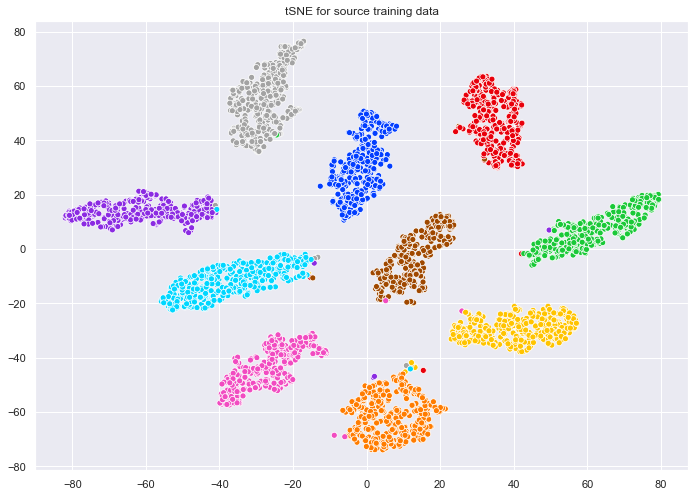

In [106]:
CNet.eval()
encoder.eval()
CNet.to(device)
encoder.to(device)
source_x_embedding_all = encoder(source_x_all)
last_layer = CNet(source_x_embedding_all)
source_x_embedding_all.shape


tsne = TSNE()
tsne_res = tsne.fit_transform(source_x_embedding_all.to('cpu').detach())

# plot
# linear unlabeled
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

g = sns.scatterplot(tsne_res[:,0], tsne_res[:,1], hue=source_y_all.to('cpu'), legend=False, palette=palette)

plt.title('tSNE for source training data')

In [107]:
target_x_all = torch.empty(0,).to(device)
target_y_all = torch.empty(0,).to(device).long()
round_ = 0
total_round = 10
for batch_id, (target_x, target_y) in tqdm(enumerate(test_svhn_loader), total=len(test_svhn_loader)):
    optimizerCNet.zero_grad()
    optimizerEncoder.zero_grad()
    target_x = target_x.to(device).float()
    target_y = target_y.to(device)
    target_x_all = torch.cat([target_x_all, target_x], dim=0)
    target_y_all = torch.cat([target_y_all, target_y], dim=0)
    round_ += 1
    if round_ >= total_round:
        break

  5%|▍         | 9/184 [00:01<00:36,  4.77it/s]


Text(0.5, 1.0, 'tSNE for target testing data')

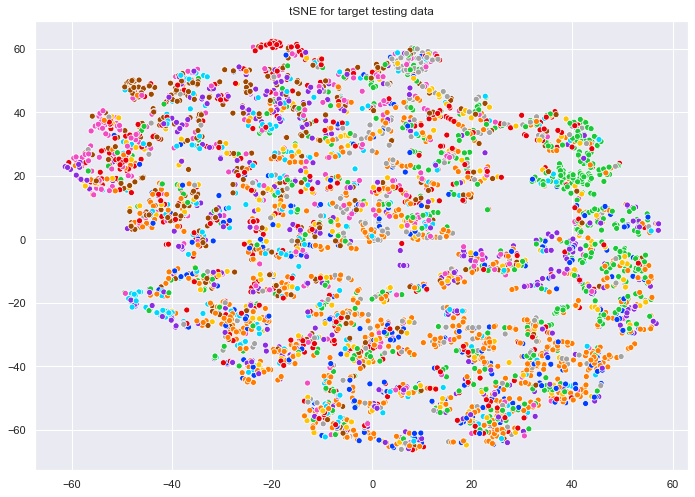

In [114]:
CNet.load_state_dict(torch.load(args.save_path + model_sub_folder+r'\acc25_CNet_13.t7', map_location=device))
encoder.load_state_dict(torch.load(args.save_path + model_sub_folder+r'\acc25_encoder_13.t7', map_location=device))
CNet.eval()
encoder.eval()
CNet.to(device)
encoder.to(device)
target_x_embedding_all = encoder(target_x_all)
last_layer = CNet(target_x_embedding_all)
target_x_embedding_all.shape


target_tsne = TSNE()
target_tsne_res = target_tsne.fit_transform(last_layer.to('cpu').detach())

# plot
# linear unlabeled
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

g = sns.scatterplot(target_tsne_res[:,0], target_tsne_res[:,1], hue=target_y_all.to('cpu'), legend=False, palette=palette)

plt.title('tSNE for target testing data')

In [111]:
model_sub_folder

'\\dann_source_only_shffle\\wtarget_0.700000_dann_weight_1.000000_learningrate_0.001000'

<All keys matched successfully>